# Sentiment Analysis for the DS Project

In [ ]:
!pip install datasets
!pip install transformers
!pip install sentence-transformers

     |████████████████████████████████| 311 kB 8.3 MB/s 
     |████████████████████████████████| 1.1 MB 33.3 MB/s 
     |████████████████████████████████| 67 kB 4.5 MB/s 
     |████████████████████████████████| 133 kB 40.2 MB/s 
     |████████████████████████████████| 243 kB 33.3 MB/s 
     |████████████████████████████████| 144 kB 34.7 MB/s 
     |████████████████████████████████| 271 kB 30.5 MB/s 
     |████████████████████████████████| 94 kB 451 kB/s 
     |████████████████████████████████| 3.5 MB 8.0 MB/s 
     |████████████████████████████████| 596 kB 31.2 MB/s 
     |████████████████████████████████| 6.8 MB 8.3 MB/s 
     |████████████████████████████████| 895 kB 36.1 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 79 kB 4.3 MB/s 
     |████████████████████████████████| 1.2 MB 23.8 MB/s 
  Created wheel for sentence-transformers: filen

## Setting Up Model 

### Reference:


https://huggingface.co/siebert/sentiment-roberta-large-english # 2 - nice, and 


@article{heitmann2020,
  title={More than a feeling: Benchmarks for sentiment analysis accuracy},
  author={Heitmann, Mark and Siebert, Christian and Hartmann, Jochen and Schamp, Christina},
  journal={Available at SSRN 3489963},
  year={2020}
}


In [ ]:
import torch
import pandas as pd
import numpy as np
from transformers import BertTokenizer, BertModel
from sentence_transformers import SentenceTransformer
from torch.utils.data import DataLoader
from sentence_transformers import losses

from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer


In [ ]:
## mounting google drive
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Model Alt 1 - Pretrained 

model_name = "siebert/sentiment-roberta-large-english"

tokenizer = AutoTokenizer.from_pretrained(model_name)

model = AutoModelForSequenceClassification.from_pretrained(model_name)


Downloading:   0%|          | 0.00/256 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/687 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/780k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.32G [00:00<?, ?B/s]

In [ ]:
# Model Alt 2 - based on Bert Base Uncased

model_name_alt = "bert_base_uncased"
tokenizer_alt =  BertTokenizer.from_pretrained('bert-base-uncased')



Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
moody_df = pd.read_csv("/content/drive/My Drive/DS Projekt/moody_df_lyrics.csv")

In [ ]:
moody_df_real =   moody_df.dropna()
moody_df_real.shape

(4213, 7)

In [ ]:
moody_df_real.mood = [1 if x == "pos" else 0 for x in moody_df_real.mood]

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


## Set Splitting

In [ ]:
# creating training, validation and test (800 in the two latter ones)

moody_df_test = moody_df_real.sample(n = 800,  replace = False, random_state = 120)
moody_train_val = moody_df_real.drop(moody_df_test.index)

moody_df_val = moody_train_val.sample(n = 800,  replace = False, random_state = 120)
moody_df_train = moody_train_val.drop(moody_df_val.index)


# Approach 1 - Pretrained Binary Sentiment Model

### Setting up dataloaders

In [ ]:
device = torch.device("cuda")
model = model.to(device)

In [ ]:
## tokeizing 

tokens_train = tokenizer.batch_encode_plus(
    list(moody_df_train.lyrics),
    max_length = 512,
    pad_to_max_length=True,
    truncation=True)

##

tokens_test = tokenizer.batch_encode_plus(
    list(moody_df_test.lyrics),
    max_length = 512,
    pad_to_max_length=True,
    truncation=True)

##

tokens_val = tokenizer.batch_encode_plus(
    list(moody_df_val.lyrics),
    max_length = 512,
    pad_to_max_length=True,
    truncation=True)


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2257: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
## function for more efficient computation

def map_for_BCELoss(tensor_in):

  ''' Function for mapping the labels. Not included in the dataloader since the simple labels are also needed.
  Tensor_in should be in '''

  list_out = []

  for label in list(tensor_in):
    if int(label) == 0:
      list_out.append([1, 0])
    else:
      list_out.append([0, 1])

  out_tensor = torch.tensor(list_out, dtype = torch.float32)
  
  return out_tensor


In [ ]:

train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(list(moody_df_train.mood))
train_y_mapped = map_for_BCELoss(moody_df_train.mood)


##

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(list(moody_df_test.mood))
test_y_mapped = map_for_BCELoss(moody_df_test.mood)


##

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(list(moody_df_val.mood))
val_y_mapped = map_for_BCELoss(moody_df_val.mood)



In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

train_data = TensorDataset(train_seq, train_mask, train_y, train_y_mapped)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=20)

##

test_data = TensorDataset(test_seq, test_mask, test_y, test_y_mapped)
test_sampler = RandomSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=20)

## 

val_data = TensorDataset(val_seq, val_mask, val_y, val_y_mapped)
val_sampler = RandomSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=20)




### Testing without training

In [ ]:
overall_f1_macros = []
overall_f1_micros = []

model.eval()

with torch.no_grad():

  for batch in test_dataloader:

    ids = batch[0].to(device)
    masks = batch[1].to(device)
    labels = batch[2].to(device)

    preds = model(ids, masks )

    # getting F1 Scores
    prediction_list = list(np.argmax(preds["logits"].cpu().detach().numpy(), axis = 1))
    ground_truths = list(list(labels.cpu().detach().numpy()))

    f1_macro = f1_score(ground_truths, prediction_list, average='macro')
    f1_micro = f1_score(ground_truths, prediction_list, average='micro')

    overall_f1_macros.append(f1_macro)
    overall_f1_micros.append(f1_micro)
    


In [ ]:
## results

print(f"The overall Macro F1 Score on all data without fine-tuning is {np.mean(overall_f1_macros)} !")
print(f"The overall Micro F1 Score on all data without fine-tuning is {np.mean(overall_f1_micros)} !")


The overall Macro F1 Score on all data without fine-tuning is 0.5743255209812668 !
The overall Micro F1 Score on all data without fine-tuning is 0.5988698505286183 !


### Fine-Tuning

### Deciding on layers to freeze

In [ ]:
for param in model.roberta.parameters():
  param.requires_grad = False

          ##

## un-freezing following layers found to be working well!

for param in model.roberta.encoder.layer[model.config.num_hidden_layers - 2].intermediate.parameters():
  param.requires_grad = True

for param in model.roberta.encoder.layer[model.config.num_hidden_layers - 2].output.parameters():
  param.requires_grad = True

          ##

for param in model.roberta.encoder.layer[model.config.num_hidden_layers - 1].intermediate.parameters():
  param.requires_grad = True

for param in model.roberta.encoder.layer[model.config.num_hidden_layers - 1].output.parameters():
  param.requires_grad = True

          ##

for param in model.classifier.parameters():
  param.requires_grad = True



In [ ]:
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr = 1e-5, weight_decay =  1e-2) # found to be working well here 



In [ ]:
model = model.to(device)

In [ ]:
## training and evaluatng (first time)

lr = 1e-5

overall_val_loss = []

for epoch in range(70):

  model.train()
  train_loss_batch = []
  for batch in train_dataloader:

    ids = batch[0].to(device)
    masks = batch[1].to(device)
    labels = batch[2].to(device)
    labels_mapped = batch[3].to(device)


    optimizer.zero_grad()

    preds = model(ids, masks)
    loss = criterion(preds["logits"], labels_mapped)
    train_loss_batch.append(loss.item())
    loss.backward()
    optimizer.step()

  
  model.eval()
  val_loss_batch = []
  with torch.no_grad():

    for batch in val_dataloader:

      ids = batch[0].to(device)
      masks = batch[1].to(device)
      labels = batch[2].to(device)
      labels_mapped = batch[3].to(device)


      preds = model(ids, masks)
      loss = criterion(preds["logits"], labels_mapped)
      val_loss_batch.append(loss.item())


  # mean losses this epoch 
  epoch_train_loss = np.mean(train_loss_batch)
  epoch_val_loss = np.mean(val_loss_batch)

  overall_val_loss.append(epoch_val_loss)


  if (np.argmax(overall_val_loss[-3::])  == 2) and (lr == 1e-5):
    optimizer = torch.optim.AdamW(model.parameters(), lr = 1e-6)
  elif (np.argmax(overall_val_loss[-3::])  == 2) and (lr == 1e-6):
    break



In [ ]:
output_model = '/content/drive/My Drive/DS Projekt/pretrained_model.pth'


def save(model, optimizer):
    # save
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }, output_model)

save(model, optimizer)


### Testing now

In [ ]:
overall_f1_macros = []
overall_f1_micros = []

model.eval()

with torch.no_grad():

  for batch in test_dataloader:

    ids = batch[0].to(device)
    masks = batch[1].to(device)
    labels = batch[2].to(device)

    preds = model(ids, masks )

    # getting F1 Scores
    prediction_list = list(np.argmax(preds["logits"].cpu().detach().numpy(), axis = 1))
    ground_truths = list(list(labels.cpu().detach().numpy()))

    f1_macro = f1_score(ground_truths, prediction_list, average='macro')
    f1_micro = f1_score(ground_truths, prediction_list, average='micro')

    overall_f1_macros.append(f1_macro)
    overall_f1_micros.append(f1_micro)
    


In [ ]:
## results

print(f"The overall Macro F1 Score on all data with fine-tuning is {np.mean(overall_f1_macros)} !")
print(f"The overall Micro F1 Score on all data with fine-tuning is {np.mean(overall_f1_micros)} !")


The overall Macro F1 Score on all data with fine-tuning is 0.6224785649315 !
The overall Micro F1 Score on all data with fine-tuning is 0.644 !


### --> does not seem to work too well. 
### Perhaps since not trained on lyrics?

# Method 2 - Bert + linear classifier layer


Based on adding linear Layer ot bert base uncased!

In [ ]:
tokenizer = tokenizer_alt

In [ ]:
## tokeizing 

tokens_train = tokenizer.batch_encode_plus(
    list(moody_df_train.lyrics),
    max_length = 512,
    pad_to_max_length=True,
    truncation=True)


##

tokens_test = tokenizer.batch_encode_plus(
    list(moody_df_test.lyrics),
    max_length = 512,
    pad_to_max_length=True,
    truncation=True)

##

tokens_val = tokenizer.batch_encode_plus(
    list(moody_df_val.lyrics),
    max_length = 512,
    pad_to_max_length=True,
    truncation=True)


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2257: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
tokens_train

In [ ]:
## function for more efficient computation

def map_for_BCELoss(tensor_in):

  ''' Function for mapping the labels. Not included in the dataloader since the simple labels are also needed.
  Tensor_in should be in '''

  list_out = []

  for label in list(tensor_in):
    if int(label) == 0:
      list_out.append([1, 0])
    else:
      list_out.append([0, 1])

  out_tensor = torch.tensor(list_out, dtype = torch.float32)
  
  return out_tensor


In [ ]:

train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(list(moody_df_train.mood))
train_y_mapped = map_for_BCELoss(moody_df_train.mood)


##

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(list(moody_df_test.mood))
test_y_mapped = map_for_BCELoss(moody_df_test.mood)


##

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(list(moody_df_val.mood))
val_y_mapped = map_for_BCELoss(moody_df_val.mood)



In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

train_data = TensorDataset(train_seq, train_mask, train_y, train_y_mapped)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=20)

##

test_data = TensorDataset(test_seq, test_mask, test_y, test_y_mapped)
test_sampler = RandomSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=20)

## 

val_data = TensorDataset(val_seq, val_mask, val_y, val_y_mapped)
val_sampler = RandomSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=20)




In [ ]:
from torch import nn

In [ ]:
class BertClassifier(nn.Module):

    def __init__(self, dropout):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # freeze all BERT parameters but pooling ones
        for param in list(self.bert.parameters())[:-2]:
          param.requires_grad = False

        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 2)   # binary output

    def forward(self, input_id, mask):


        # just the pooled output
        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
       
        return linear_output



In [ ]:
model = BertClassifier(0.05)

device = torch.device("cuda")
model = model.to(device)


Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)


### Hyper-Param Tuning 

In [ ]:
dropouts = [0, 0.05, 1]
l_rates = [1e-2, 1e-3, 1e-4]


In [ ]:
i = 0

for d in dropouts:
  for l in l_rates:

    model = BertClassifier( d )

    device = torch.device("cuda")
    model = model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr = l )

    #print(f"Starting with combo of drop = {d} and lr equal to {l} ")


    for epoch in range(7):

      model.train()
      for batch in train_dataloader:

        ids = batch[0].to(device)
        masks = batch[1].to(device)
        labels = batch[2].to(device)
        labels_mapped = batch[3].to(device)


        optimizer.zero_grad()

        preds = model(ids, masks)
        loss = criterion(preds, labels_mapped)
        loss.backward()
        optimizer.step()
      
      model.eval()
      val_loss_batch = []
      with torch.no_grad():

        for batch in val_dataloader:

          ids = batch[0].to(device)
          masks = batch[1].to(device)
          labels = batch[2].to(device)
          labels_mapped = batch[3].to(device)


          preds = model(ids, masks)
          loss = criterion(preds, labels_mapped)
          val_loss_batch.append(loss.item())


      # mean losses this epoch 
      epoch_val_loss = np.mean(val_loss_batch)

      print(f"Epoch: {epoch}, Val Loss of {epoch_val_loss} ")



Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: 0, Val Loss of 0.5542474158108235 
Epoch: 1, Val Loss of 0.5278648257255554 
Epoch: 2, Val Loss of 1.3564705282449723 
Epoch: 3, Val Loss of 0.573377226293087 
Epoch: 4, Val Loss of 0.540196992084384 
Epoch: 5, Val Loss of 0.5704655207693576 
Epoch: 6, Val Loss of 0.5875666186213493 


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: 0, Val Loss of 0.5201423972845077 
Epoch: 1, Val Loss of 0.505012309551239 
Epoch: 2, Val Loss of 0.5515905946493149 
Epoch: 3, Val Loss of 0.5041360490024089 
Epoch: 4, Val Loss of 0.5421544715762139 
Epoch: 5, Val Loss of 0.5793787457048893 
Epoch: 6, Val Loss of 0.5140831589698791 


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: 0, Val Loss of 0.588172622025013 
Epoch: 1, Val Loss of 0.5539781883358955 
Epoch: 2, Val Loss of 0.525705985724926 
Epoch: 3, Val Loss of 0.5217806860804558 
Epoch: 4, Val Loss of 0.5041247971355916 
Epoch: 5, Val Loss of 0.5012587666511535 
Epoch: 6, Val Loss of 0.5002670004963875 


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: 0, Val Loss of 0.568113686144352 
Epoch: 1, Val Loss of 0.7319554150104522 
Epoch: 2, Val Loss of 0.5487802974879742 
Epoch: 3, Val Loss of 0.5596634775400162 
Epoch: 4, Val Loss of 0.7406959392130374 
Epoch: 5, Val Loss of 0.5670771338045597 
Epoch: 6, Val Loss of 0.5755833208560943 


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: 0, Val Loss of 0.5181392006576061 
Epoch: 1, Val Loss of 0.49619135111570356 
Epoch: 2, Val Loss of 0.5176287494599819 
Epoch: 3, Val Loss of 0.5177201829850674 
Epoch: 4, Val Loss of 0.5094950340688229 
Epoch: 5, Val Loss of 0.49901390001177787 
Epoch: 6, Val Loss of 0.4990039512515068 


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: 0, Val Loss of 0.5915098525583744 
Epoch: 1, Val Loss of 0.5532816417515278 
Epoch: 2, Val Loss of 0.5437489725649357 
Epoch: 3, Val Loss of 0.5449558191001416 
Epoch: 4, Val Loss of 0.5230822950601578 
Epoch: 5, Val Loss of 0.5058058734983206 
Epoch: 6, Val Loss of 0.5038870878517627 


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: 0, Val Loss of 0.7273596793413162 
Epoch: 1, Val Loss of 0.723158173263073 
Epoch: 2, Val Loss of 0.718185330927372 
Epoch: 3, Val Loss of 0.7276107192039489 
Epoch: 4, Val Loss of 0.726470397412777 
Epoch: 5, Val Loss of 0.7313813358545304 
Epoch: 6, Val Loss of 0.7240312799811364 


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: 0, Val Loss of 0.7120023727416992 
Epoch: 1, Val Loss of 0.7119158118963241 
Epoch: 2, Val Loss of 0.7121795251965523 
Epoch: 3, Val Loss of 0.7120139956474304 
Epoch: 4, Val Loss of 0.71221072524786 
Epoch: 5, Val Loss of 0.7122486352920532 
Epoch: 6, Val Loss of 0.7120148584246635 


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: 0, Val Loss of 0.713646100461483 
Epoch: 1, Val Loss of 0.713628762960434 
Epoch: 2, Val Loss of 0.713612225651741 
Epoch: 3, Val Loss of 0.7135959848761558 
Epoch: 4, Val Loss of 0.7135804578661918 
Epoch: 5, Val Loss of 0.7135656923055649 
Epoch: 6, Val Loss of 0.7135512754321098 


--> As can be seen, a combination of a dropout rate of 0.05 and a learning rate 0f 0.05 is the most promising. 

Hence, retraining the model with hese params using early stopping.

In [ ]:
model = BertClassifier( 0.05 ) 

device = torch.device("cuda")
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr = 1e-5 )


overall_loss = []

for epoch in range(70):

  model.train()
  for batch in train_dataloader:

    ids = batch[0].to(device)
    masks = batch[1].to(device)
    labels = batch[2].to(device)
    labels_mapped = batch[3].to(device)


    optimizer.zero_grad()

    preds = model(ids, masks)
    loss = criterion(preds, labels_mapped)
    loss.backward()
    optimizer.step()
  
  model.eval()
  val_loss_batch = []
  with torch.no_grad():

    for batch in val_dataloader:

      ids = batch[0].to(device)
      masks = batch[1].to(device)
      labels = batch[2].to(device)
      labels_mapped = batch[3].to(device)


      preds = model(ids, masks)
      loss = criterion(preds, labels_mapped)
      val_loss_batch.append(loss.item())


  # mean losses this epoch 
  epoch_val_loss = np.mean(val_loss_batch)

  overall_loss.append(epoch_val_loss)

  if np.argmax(overall_loss[-4::])  == 2:
    break

#  print(f"Epoch: {epoch}, Val Loss of {epoch_val_loss} ")




Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# saving 

# save

# save
output_model = '/content/drive/My Drive/DS Projekt/bert_1_linear.pth'


def save(model, optimizer):
    # save
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }, output_model)

save(model, optimizer)




In [ ]:
from sklearn.metrics import f1_score

In [ ]:
overall_f1_macros = []
overall_f1_micros = []

model.eval()

with torch.no_grad():

  for batch in test_dataloader:

    ids = batch[0].to(device)
    masks = batch[1].to(device)
    labels = batch[2].to(device)

    preds = model(ids, masks )

    # getting F1 Scores
    prediction_list = list(np.argmax(preds.cpu().detach().numpy(), axis = 1))
    ground_truths = list(list(labels.cpu().detach().numpy()))

    f1_macro = f1_score(ground_truths, prediction_list, average='macro')
    f1_micro = f1_score(ground_truths, prediction_list, average='micro')

    overall_f1_macros.append(f1_macro)
    overall_f1_micros.append(f1_micro)
    


In [ ]:
## results - simple new Network

print(f"The overall Macro F1 Score on all data without fine-tuning is {np.mean(overall_f1_macros)} !")
print(f"The overall Micro F1 Score on all data without fine-tuning is {np.mean(overall_f1_micros)} !")


The overall Macro F1 Score on all data with fine-tuning is 0.6997830390397298 !
The overall Micro F1 Score on all data with fine-tuning is 0.73375 !


## Approach 3 - BERT + 2 linear layers


In [ ]:
from torch import nn

In [ ]:
class BertClassifier(nn.Module):

    def __init__(self, dropout_1, hidden_dim, dropout_2):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # freeze all BERT parameters but pooling ones
        for param in list(self.bert.parameters())[:-2]:
          param.requires_grad = False

        self.dropout_1 = nn.Dropout(dropout_1)
        self.linear_1 = nn.Linear(768, hidden_dim)

        self.tanh = nn.Tanh()
        
        self.dropout_2 = nn.Dropout(dropout_2)
        self.linear_2 = nn.Linear(hidden_dim, 2)

        

    def forward(self, input_id, mask):


        # just the pooled output
        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout_1(pooled_output)
        linear_output = self.linear_1(dropout_output)

        intrmeditate_output = self.tanh(linear_output)

        dropout_output_2 = self.dropout_2(linear_output)
        final_output = self.linear_2(dropout_output_2)
       
        return final_output



In [ ]:
criterion = torch.nn.BCEWithLogitsLoss()

### Hyper-Param Tuning 

In [ ]:
dropouts = [0.05, 1] # für beide 
l_rates = [ 1e-3, 1e-4]
hidden_dims = [50,100,150]


In [ ]:
result_matrix = np.ones([12,8])

In [ ]:
i = 0

for d in dropouts:
  for l in l_rates:
    for h in hidden_dims:

      model = BertClassifier( d, h, d )

      device = torch.device("cuda")
      model = model.to(device)

      optimizer = torch.optim.Adam(model.parameters(), lr = l )

     # print(f"Starting with combo of drop = {d} and lr equal to {l} ")


      for epoch in range(7):

        model.train()
        for batch in train_dataloader:

          ids = batch[0].to(device)
          masks = batch[1].to(device)
          labels = batch[2].to(device)
          labels_mapped = batch[3].to(device)


          optimizer.zero_grad()

          preds = model(ids, masks)
          loss = criterion(preds, labels_mapped)
          loss.backward()
          optimizer.step()
        
        model.eval()
        val_loss_batch = []
        with torch.no_grad():

          for batch in val_dataloader:

            ids = batch[0].to(device)
            masks = batch[1].to(device)
            labels = batch[2].to(device)
            labels_mapped = batch[3].to(device)


            preds = model(ids, masks)
            loss = criterion(preds, labels_mapped)
            val_loss_batch.append(loss.item())


        # mean losses this epoch 
        epoch_val_loss = np.mean(val_loss_batch)

       # print(f"Epoch: {epoch}, Val Loss of {epoch_val_loss} ")

        result_matrix[i, epoch] = epoch_val_loss


      i += 1


In [ ]:
result_matrix.shape

(12, 8)

In [ ]:
result_matrix[0,:7]

array([0.57305476, 0.52507873, 0.53483625, 0.50362083, 0.51605611,
       0.58576899, 0.49521067])

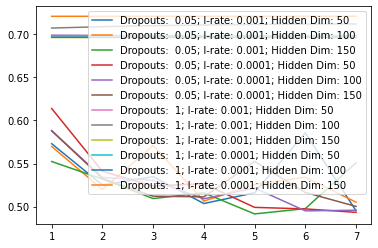

In [ ]:
## Plotting outputs 
import matplotlib.pyplot as plt

epochs = list(range(1,8))

plt.plot(epochs, result_matrix[0,:7])
plt.plot(epochs, result_matrix[1,:7])
plt.plot(epochs, result_matrix[2,:7])
plt.plot(epochs, result_matrix[3,:7])
plt.plot(epochs, result_matrix[4,:7])
plt.plot(epochs, result_matrix[5,:7])
plt.plot(epochs, result_matrix[6,:7])
plt.plot(epochs, result_matrix[7,:7])
plt.plot(epochs, result_matrix[8,:7])
plt.plot(epochs, result_matrix[9,:7])
plt.plot(epochs, result_matrix[10,:7])
plt.plot(epochs, result_matrix[11,:7])


# adding legend
labels = []


for d in dropouts:
  for l in l_rates:
    for h in hidden_dims:

      labels.append(str("Dropouts:  " + str(d) + "; l-rate: " + str(l) + "; Hidden Dim: " + str(h) ) )

plt.legend(labels, loc='upper right')
plt.show()

--> dropouts of 0.05 and 50 as hidden dim and 1e-4 as learning rate seems to be doing well. High hidden dimensions lead to straight overfitting.

Fine-tuning model with best hyper-params

In [ ]:
model = BertClassifier( 0.05, 50, 0.05 ) 

device = torch.device("cuda")
model = model.to(device)

lr = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr = lr)
criterion = torch.nn.BCEWithLogitsLoss()

overall_loss = []

for epoch in range(70):

  model.train()
  for batch in train_dataloader:

    ids = batch[0].to(device)
    masks = batch[1].to(device)
    labels = batch[2].to(device)
    labels_mapped = batch[3].to(device)


    optimizer.zero_grad()

    preds = model(ids, masks)
    loss = criterion(preds, labels_mapped)
    loss.backward()
    optimizer.step()
  
  model.eval()
  val_loss_batch = []
  with torch.no_grad():

    for batch in val_dataloader:

      ids = batch[0].to(device)
      masks = batch[1].to(device)
      labels = batch[2].to(device)
      labels_mapped = batch[3].to(device)


      preds = model(ids, masks)
      loss = criterion(preds, labels_mapped)
      val_loss_batch.append(loss.item())


  # mean losses this epoch 
  epoch_val_loss = np.mean(val_loss_batch)

  overall_loss.append(epoch_val_loss)

  if (np.argmax(overall_loss[-3::])  == 2) and (lr == 1e-4):
    optimizer = torch.optim.AdamW(model.parameters(), lr = 1e-5)
  elif (np.argmax(overall_loss[-3::])  == 2) and (lr == 1e-5):
    break

#  print(f"Epoch: {epoch}, Val Loss of {epoch_val_loss} ")




Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# save
output_model = '/content/drive/My Drive/DS Projekt/bert_2_linear.pth'


def save(model, optimizer):
    # save
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }, output_model)

save(model, optimizer)



In [ ]:
# load
model = model = BertClassifier( 0.05, 50, 0.05 ) 
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4)

output_model = '/content/drive/My Drive/DS Projekt/bert_2_linear.pth'


checkpoint = torch.load(output_model, map_location='cpu')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
device = torch.device("cuda")
model = model.to(device)

In [ ]:
from sklearn.metrics import f1_score

In [ ]:
overall_f1_macros = []
overall_f1_micros = []

model.eval()

with torch.no_grad():

  for batch in test_dataloader:

    ids = batch[0].to(device)
    masks = batch[1].to(device)
    labels = batch[2].to(device)

    preds = model(ids, masks )

    # getting F1 Scores
    prediction_list = list(np.argmax(preds.cpu().detach().numpy(), axis = 1))
    ground_truths = list(list(labels.cpu().detach().numpy()))

    f1_macro = f1_score(ground_truths, prediction_list, average='macro')
    f1_micro = f1_score(ground_truths, prediction_list, average='micro')

    overall_f1_macros.append(f1_macro)
    overall_f1_micros.append(f1_micro)
    


In [ ]:
## results - simple new Network

print(f"The overall Macro F1 Score on all data without fine-tuning is {np.mean(overall_f1_macros)} !")
print(f"The overall Micro F1 Score on all data without fine-tuning is {np.mean(overall_f1_micros)} !")


The overall Macro F1 Score on all data without fine-tuning is 0.835883214399289 !
The overall Micro F1 Score on all data without fine-tuning is 0.83405 !


## Applying this model to all available Lyrics data

In [ ]:
tokenizer = tokenizer_alt

In [ ]:
data_BERT = pd.read_csv("/content/drive/My Drive/DS Projekt/data_for_BERT.csv", encoding = "latin")

In [ ]:
tokens = tokenizer.batch_encode_plus(
    data_BERT.lyrics,
    max_length = 512,
    pad_to_max_length=True,
    truncation=True)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2257: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
seq = torch.tensor(tokens['input_ids'])
mask = torch.tensor(tokens['attention_mask'])
ids = seq.to(device)
masks = mask.to(device)


In [ ]:
import gc
del model
gc.collect()

3563

In [ ]:
def softmax(aa):
  
  ret_1 = np.exp(aa[0][0]) /  ( np.exp(aa[0][0]) + np.exp(aa[0][1]) )
  ret_2 = np.exp(aa[0][1]) /  ( np.exp(aa[0][0]) + np.exp(aa[0][1]) )

  return ret_2


In [ ]:
# applying to all 

sent_per_pos = []

for i in range(data_BERT.shape[0]):


  ids_here =  ids[i].reshape(1,512)
  masks_here = masks[i].reshape(1,512)

  with torch.no_grad():
    preds = model(ids_here, masks_here)
  
  preds2 = preds.cpu().detach().numpy()

  preds3 = softmax(preds2)

  sent_per_pos.append(preds3)
#  print(i)
#  print(preds3)
  


In [ ]:
data_BERT["sent_per_pos"] = sent_per_pos

In [ ]:
data_BERT_Sent = data_BERT[["combination", "sent_per_pos"]]

In [ ]:
data_BERT_Sent.to_csv("/content/drive/My Drive/DS Projekt/data_BERT_Sent.csv")

